<a href="https://colab.research.google.com/github/Sassotek/Mechanistic-Interpretability-for-Vision-Models-Optimization/blob/main/Mechanistic_Interpretability_for_Vision_Models_Optimization_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Notes

In [1]:
!swd

/bin/bash: line 1: swd: command not found


##########Dataset Description
File descriptions

    train.images.zip - the training set (images distributed into class labeled folders)
    test.zip
   
    wnids.txt - list of the used ids from the original full set of ImageNet
    words.txt - description of all ids of ImageNet


+++++ https://www.kaggle.com/datasets/wissamsalam/tiny-imagenet-cleaned-for-classification


https://viso.ai/deep-learning/vision-transformer-vit/

https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch

https://docs.pytorch.org/vision/main/models/vision_transformer.html

https://github.com/lucidrains/vit-pytorch

https://arxiv.org/pdf/2010.11929.pdf

https://www.youtube.com/watch?v=j3VNqtJUoz0

https://www.youtube.com/watch?v=vJF3TBI8esQ

https://www.youtube.com/watch?v=nZ22Ecg9XCQ


** Dataset link sbagliato**
https://www.kaggle.com/c/tiny-imagenet


Gradient Plot
https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/37

#####GuidaEinops

https://nbviewer.org/github/arogozhnikov/einops/blob/main/docs/1-einops-basics.ipynb


**latent_size** (o anche detto embedding_dim, hidden_dim, ecc.) è la dimensione del vettore che rappresenta ogni patch dopo la proiezione lineare, ovvero la dimensione dello spazio latente in cui il modello "lavora".

**class token** per ogni batch, un vettore speciale che sarà usato dal ViT per l'output della classificazione.

**positional embedding** iniziale. Verrà poi ripetuta per il numero di patch + 1 (per il class token). Serve a dare informazioni sulla posizione dei patch nel Transformer.

**patches = einops.rearrange**(
    input,
    'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
    p1=self.patch_size, p2=self.patch_size
)*
Usa Einops per dividere ogni immagine in patch:

    Input: (b, c, H, W)

    Output: (b, N_patch, patch_dim), dove:

        N_patch = (H // patch_size) * (W // patch_size)

        patch_dim = patch_size * patch_size * c

Esempio: immagine 64x64, patch_size=16 → 16 patch da 16x16x3

In [2]:
#save_path_model= ................./ciao.pth
#save_path_opt= ..../ott.pth

# Running Settings

In [3]:
Pi_gpu=0

if(Pi_gpu):
  pass

#Imports

In [4]:
import math
import matplotlib
import matplotlib.pyplot as plt
plt.ion()
import plotly.graph_objects as go
from matplotlib.gridspec import GridSpec
from matplotlib.patches import FancyArrowPatch
import numpy as np
from PIL import Image
import cv2
from skimage import io, color
from collections import Counter


#Kaggle
!pip install kagglehub --quiet
import kagglehub


#PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import ModuleList
from torch.utils.data import Dataset,DataLoader, SubsetRandomSampler, ConcatDataset
import torchvision
from torchvision import transforms,datasets
import torchvision.transforms.functional as TF
from torchsummary import summary
import torch.optim as optim


import random
import os
import pandas as pd
from tqdm.notebook import tqdm
import time
import seaborn as sns
import einops
import sys
import requests
import urllib.request
from io import BytesIO
from prettytable import PrettyTable
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift


from IPython.display import display, Markdown, clear_output
from IPython.display import HTML
import ipywidgets as widgets
from ipywidgets import interact, IntSlider, FloatSlider, FloatRangeSlider, Dropdown, Output


import sklearn
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from timm.data import Mixup
from timm.loss import SoftTargetCrossEntropy
from torch.optim.lr_scheduler import CosineAnnealingLR


# Setting the seed
torch.manual_seed(240700)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Device",device)
if torch.cuda.is_available():
   torch.cuda.manual_seed(240700)
   torch.cuda.manual_seed_all(240700)

#ensure that all operations are deterministic on GPU if used,for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device cuda


In [5]:
device_list = ["NVIDIA GeForce RTX 3070", ""]

def hardware_check():
    # Check if GPU is available and return the device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        device_name = torch.cuda.get_device_name()
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        #print(f"  -> Total Memory: {torch.cuda.get_device_properties().total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        # Fix the backslash issue in the command string by escaping it
        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device, device_name

device, device_name = hardware_check()
print(f"\nUsing {device} for computation")


## Google Drive settings, only if is not local runtime
if device_name not in device_list:
  from google.colab.patches import cv2_imshow
  from google.colab import drive
  drive.mount('/content/drive')


GPU is available!
  -> GPU - NVIDIA GeForce RTX 3070

Using cuda for computation


# Globals

In [6]:
directory_file_path="/content/drive/File_projects_CV"
path_saves = "/home/user/work/Saved_Models"
local_path = "/home/user/work/tiny-imagenet-200"

RED = "\033[31m"
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"
CYAN="\033[36m"
MAGENTA="\033[35m"

#Transformer hyperparameters
patch_size = 16
latent_size = 768
n_channels = 3
n_heads = 12
n_encoders = 12
dropout = 0.3
n_classes = 200 #According to tinyimagenet
image_size = 64 #According to tinyimagenet

#Training
epochs = 10
batch_size = 4
threshold = 10e-3
weight_decay = 0.01

# ImageNet mean and std
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

#Data

##Dataset Loading

In [7]:
#data_path = kagglehub.dataset_download("akash2sharma/tiny-imagenet")
if device_name in device_list:
  data_path = local_path
else:
  data_path= kagglehub.dataset_download("wissamsalam/tiny-imagenet-cleaned-for-classification")
  data_path= data_path+'/tiny-imagenet-200/'
  print("Path to dataset files:", data_path)

In [8]:
def print_dataset_structure(root_dir, max_classes=3, max_images=3):
    print(f"📁 Directory: {root_dir}\n")

    class_dirs_all = []
    root_items = sorted(os.listdir(root_dir))
    for item in root_items:
        item_path = os.path.join(root_dir, item)

        if os.path.isfile(item_path):
            print(f"📄 {item}")

        elif os.path.isdir(item_path) and item in ['train', 'val', 'test']:
            print(f"\n📂 {item}/")

            class_dirs_all = sorted([
                d for d in os.listdir(item_path)
                if os.path.isdir(os.path.join(item_path, d))
            ])
            class_dirs = class_dirs_all[:max_classes]

            if not class_dirs:
                print(f"  (No subdirectory found into {item}/)")
                continue

            for cls in class_dirs:
                cls_path = os.path.join(item_path, cls)
                print(f"  ├── {cls}/")

                image_files_all = sorted([
                    f for f in os.listdir(cls_path)
                    if os.path.isfile(os.path.join(cls_path, f))
                ])
                image_files = image_files_all[:max_images]

                for img in image_files:
                    print(f"  │   ├── {img}")

                if len(image_files_all) > max_images:
                    print(f"  │   └── ...")

            if len(class_dirs_all) > max_classes:
                print(f"  └── ...")

    dataset_data = []

    for item_ in root_items:
        item_path_ = os.path.join(root_dir, item_)

        if os.path.isdir(item_path_) and item_ in ['train', 'val', 'test']:
            class_dirs_ = sorted([
                d for d in os.listdir(item_path_)
                if os.path.isdir(os.path.join(item_path_, d))
            ])

            if not class_dirs_:
                continue

            for cls in class_dirs_:
                cls_path_ = os.path.join(item_path_, cls)

                image_files_ = sorted([
                    f for f in os.listdir(cls_path_)
                    if os.path.isfile(os.path.join(cls_path_, f))
                ])
                if(item_ == 'train'):
                  size = len(image_files_)-1
                else:
                  size = len(image_files_)
                dataset_data.append((item_, cls, size))

    return class_dirs_all, dataset_data

In [9]:
#Print some data about the dataset
print(data_path)
class_labels , data = print_dataset_structure(data_path)
labels_encoding = {label: i for i, label in enumerate(class_labels)}
set_samples = {}

for set_, lab, num in data:
    if(set_ not in set_samples):
        set_samples[set_] = {}
        set_samples[set_] = (num, 1)
    else:
        set_samples[set_] = (set_samples[set_][0]+num, set_samples[set_][1]+1)

mean_for_training = set_samples['train'][0]/set_samples['train'][1]
mean_for_validation = set_samples['val'][0]/set_samples['val'][1]
mean_for_test = set_samples['test'][0]/set_samples['test'][1]

print("\n")
print("Raw Data")
print(data)
print("\n")
print("Mean_for_training")
print(mean_for_training)
print("Mean_for_validation")
print(mean_for_validation)
print("Mean_for_test")
print(mean_for_test)
print("\n")

samples_by_set = {}

c = 0
for set_, lab, num in data:
  if set_ == 'train':
    if num != mean_for_training:
      print("Train dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'val':
    if num != mean_for_validation:
      print("Validation dimensions different for mean for class "+lab)
      c = 1
  elif set_ == 'test':
    if num != mean_for_test:
      print("Test dimensions different for mean for class "+lab)
      c = 1

if c == 0:
  print("Class distributions identical\n")
  samples_by_set = {'train': int(mean_for_training),
                    'val': int(mean_for_validation),
                    'test': int(mean_for_test)
                    }


print("All Class Labels")
print(class_labels)
print("\n")
print("Number of Class Labels")
print(len(class_labels))
print("\n")
print("Lables Encoding")
print(labels_encoding)

/home/user/work/tiny-imagenet-200
📁 Directory: /home/user/work/tiny-imagenet-200


📂 test/
  ├── n01443537/
  │   ├── n01443537_0.JPEG
  │   ├── n01443537_1.JPEG
  │   ├── n01443537_101.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_0.JPEG
  │   ├── n01629819_1.JPEG
  │   ├── n01629819_10.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_0.JPEG
  │   ├── n01641577_1.JPEG
  │   ├── n01641577_104.JPEG
  │   └── ...
  └── ...

📂 train/
  ├── n01443537/
  │   ├── n01443537_10.JPEG
  │   ├── n01443537_100.JPEG
  │   ├── n01443537_102.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── n01629819_100.JPEG
  │   ├── n01629819_101.JPEG
  │   ├── n01629819_102.JPEG
  │   └── ...
  ├── n01641577/
  │   ├── n01641577_10.JPEG
  │   ├── n01641577_100.JPEG
  │   ├── n01641577_101.JPEG
  │   └── ...
  └── ...

📂 val/
  ├── n01443537/
  │   ├── val_1230.JPEG
  │   ├── val_1267.JPEG
  │   ├── val_1284.JPEG
  │   └── ...
  ├── n01629819/
  │   ├── val_1054.JPEG
  │   ├── val_1167.JPEG
  │   ├── 

##Transforms



In [10]:
#Must apply the essentials transforms
def DataTransform(image, label, size = (image_size, image_size)):

  image_t=None
  # Convert to tensor if needed
  if not isinstance(image, torch.Tensor):
    image_t = transforms.ToTensor()(image)

  #encode label
  label_t = labels_encoding[label]

  #normalizzation
  image_t = TF.normalize(
            image_t,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
  #resizing (?)

  result = {'image': image_t, 'label': label_t}
  return result



In [11]:

def denormalize(tensor, mean, std):
    """
    tensor: torch.Tensor C×H×W normalized
    mean, std: liste di lunghezza C
    return: torch.Tensor C×H×W denormalized
    """
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    std  = torch.tensor(std,  dtype=tensor.dtype, device=tensor.device).view(-1,1,1)
    img = tensor * std + mean
    return img.clamp(0, 1)

##Data Augmentation

In [12]:
def DataAugmentation(image, aug_prob = 0.50):
  # 1. Random Horizontal Flip
  if random.random() < aug_prob:
      #print("Random Horizontal Flip")
      image = TF.hflip(image)

  # 2. Random Crop (with probability)
  if random.random() < aug_prob:
      #print("Random Crop")
      # Get original dimensions
      h, w = image.shape[1:3]

      # Determine crop dimensions (between 80-100% of original dimensions)
      new_h = int(h * random.uniform(0.8, 1.0))
      new_w = int(w * random.uniform(0.8, 1.0))

      # Determine crop position
      top = random.randint(0, h - new_h)
      left = random.randint(0, w - new_w)

      # Apply crop
      image = image[:, top:top + new_h, left:left + new_w]

      # Resize back to original dimensions
      image = TF.resize(image, [h, w],
                                        interpolation=transforms.InterpolationMode.BILINEAR)

  # 3. Random Rotation (small angles)
  if random.random() < aug_prob:
      #print("Random Rotation")
      angle = random.uniform(-15, 15)  # Rotation of ±15 degrees
      image = TF.rotate(image, angle,
                                        interpolation=transforms.InterpolationMode.BILINEAR)

  # 4. Random Color Jitter (only for RGB image)
  if random.random() < aug_prob:
      #print("Random Color Jitter")
      color_jitter = transforms.ColorJitter(
          brightness=0.2,
          contrast=0.2,
          saturation=0.2,
          hue=0.1
      )
      image = color_jitter(image)

  # 5. Random Gaussian Noise (only for RGB image)
  if random.random() < aug_prob:
      #print("Random Gaussian Noise")
      noise = torch.randn_like(image) * 0.02  # Adjust standard deviation to control noise intensity
      image = torch.clamp(image + noise, 0.0, 1.0)  # Clamp values between 0 and 1

  return image

##Dataset Loader


In [13]:
class DatasetLoader(Dataset):
    def __init__(self, root_dir, mode, transform_size = (image_size, image_size), augmentation = False):
        self.root_dir = root_dir
        self.mode = mode
        self.transform_size = transform_size
        self.augmentation = augmentation and mode == 'train'
        self.samples = [] #flatten the dataset

        if self.mode == 'train':
            self.data_path = os.path.join(self.root_dir, 'train')
        elif self.mode == 'test':
            self.data_path = os.path.join(self.root_dir, 'test')
        elif self.mode == 'val':
            self.data_path = os.path.join(self.root_dir, 'val')
        else:
          raise ValueError("Invalid mode")

        self.labels = sorted([d for d in os.listdir(self.data_path)])

        for label_idx, label in enumerate(self.labels):
            label_dir = os.path.join(self.data_path, label)
            image_files = sorted(os.listdir(label_dir))
            for img_file in image_files:
                if(img_file != label + "_boxes.txt"):
                  img_path = os.path.join(label_dir, img_file)
                  self.samples.append(( label, img_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        label_name, img_path = self.samples[idx]
        #print("im in getitem")
        #print(label_name)
        #print(img_path)

        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e

        trans = DataTransform(image, label_name, self.transform_size)
        image = trans['image']
        label = trans['label']

        if(self.augmentation):
            image = DataAugmentation(image)

        return {'image': image, 'label': label}


    def getitem(self, chosen_label, idx):
        if(chosen_label not in self.labels):
            print("Invalid label for "+self.mode)
            return None

        sample_path = os.path.join(self.data_path, chosen_label)

        image_files = sorted([
                    f for f in os.listdir(sample_path)
                ])

        sample_number = len(image_files)

        if(idx > sample_number):
          print("Invalid index for "+chosen_label+" in "+self.mode)

        image_idx = image_files[idx]
        #print(image_idx)
        try:
            image = Image.open(os.path.join(sample_path, image_idx)).convert('RGB')
        except Exception as e:
            print(f"Error loading image")
            raise e
        #print(image)

        trans = DataTransform(image, chosen_label, self.transform_size)
        image = trans['image']
        label = trans['label']

        if(self.augmentation):
            image = DataAugmentation(image)

        return {'image': image, 'label': label}

##Show Sample

In [14]:
def show_sample_1(dataset, label_1, idx_1, label_2, idx_2):
    sample_1 = dataset.getitem(label_1, idx_1)
    image_1 = sample_1['image']
    image_1 = denormalize(image_1, MEAN, STD)
    label_1 = sample_1['label']
    image_1 = image_1.permute(1, 2, 0).numpy()

    sample_2 = dataset.getitem(label_2, idx_2)
    image_2 = sample_2['image']
    image_2= denormalize(image_2, MEAN, STD)
    label_2 = sample_2['label']
    image_2 = image_2.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First image
    axs[0].imshow(image_1)
    #axs[0].set_title(f"Label: {label_1}")
    axs[0].set_title(f"Pietro")
    axs[0].set_xlabel('Width (pixels)')
    axs[0].set_ylabel('Height (pixels)')
    axs[0].grid(False)

    # Second image
    axs[1].imshow(image_2)
    #axs[1].set_title(f"Label: {label_2}")
    axs[1].set_title(f"Cami")
    axs[1].set_xlabel('Width (pixels)')
    axs[1].set_ylabel('Height (pixels)')
    axs[1].grid(False)

    plt.show()

def show_sample_2(dataset, mode, label_1, idx_1, label_2, idx_2):
    label_dec_1 = labels_encoding[label_1]
    label_dec_2 = labels_encoding[label_2]

    mul = 0

    if(mode == 'train'):
        mul = samples_by_set['train']
    elif(mode == 'val'):
        mul = samples_by_set['val']
    elif(mode == 'test'):
        mul = samples_by_set['test']
    else:
        print("Invalid mode")
        return

    sample_idx_1 = label_dec_1*mul+idx_1
    sample_idx_2 = label_dec_2*mul+idx_2

    sample_1 = dataset[sample_idx_1]
    image_1 = sample_1['image']
    image_1 = denormalize(image_1, MEAN, STD)
    label_1 = sample_1['label']
    image_1 = image_1.permute(1, 2, 0).numpy()

    sample_2 = dataset[sample_idx_2]
    image_2 = sample_2['image']
    image_2= denormalize(image_2, MEAN, STD)
    label_2 = sample_2['label']
    image_2 = image_2.permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # First image
    axs[0].imshow(image_1)
    #axs[0].set_title(f"Label: {label_1}")
    axs[0].set_title(f"Pietro")
    axs[0].set_xlabel('Width (pixels)')
    axs[0].set_ylabel('Height (pixels)')
    axs[0].grid(False)

    # Second image
    axs[1].imshow(image_2)
    #axs[1].set_title(f"Label: {label_2}")
    axs[1].set_title(f"Cami")
    axs[1].set_xlabel('Width (pixels)')
    axs[1].set_ylabel('Height (pixels)')
    axs[1].grid(False)

    plt.show()



Let's visualize a pic :D


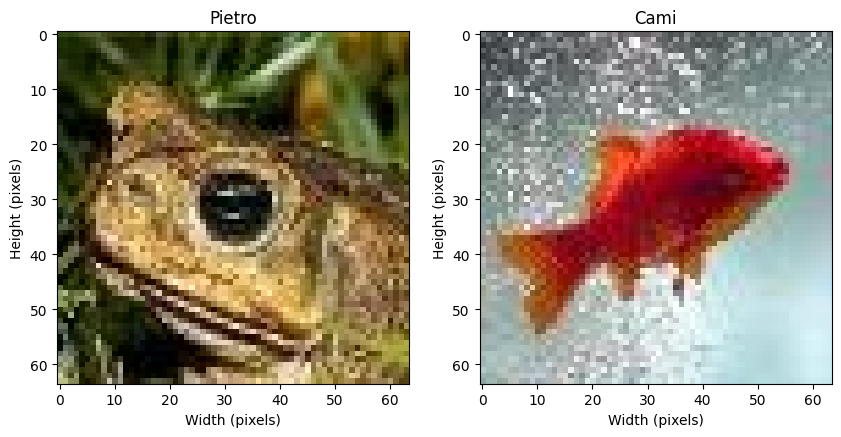

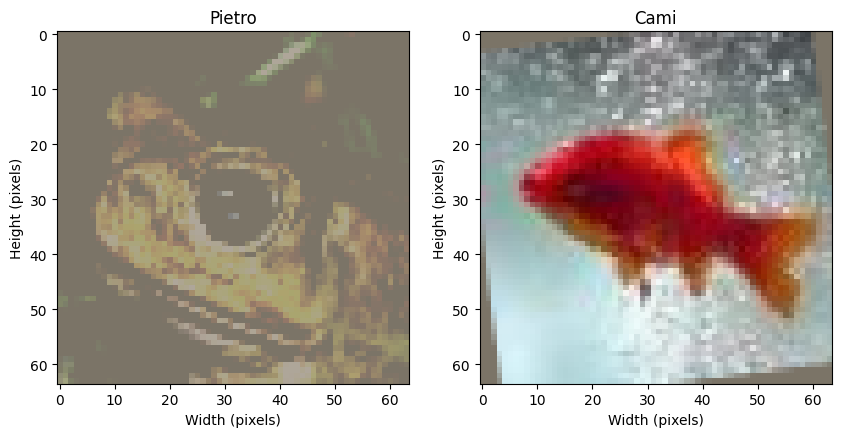

In [15]:
mode = 'train'
datset_1 = DatasetLoader(data_path, mode, augmentation=False)
datset_2 = DatasetLoader(data_path, mode, augmentation=True)
#show_sample_1(datset_1, 'n01644900', 0, 'n01443537', 0)
show_sample_2(datset_1, mode, 'n01644900', 0, 'n01443537', 0)
show_sample_2(datset_2, mode, 'n01644900', 0, 'n01443537', 0)

#Network Functions


##Test Sasso

In [16]:
class PatchEmbedding(nn.Module):
  def __init__(self,
               img_size,
               patch_size,
               channels,
               latent_size):
    super().__init__()
    #self.img_size = img_size
    self.patch_size = patch_size
    #self.channels = channels
    #self.latent_size = latent_size
    self.proj = nn.Conv2d(in_channels= channels,
                          out_channels= latent_size,
                          kernel_size= patch_size,
                          stride= patch_size)

    self.num_patches = (img_size // patch_size)**2

    self.cls_token = nn.Parameter(torch.randn(1, 1, latent_size)) #classification token to train
    self.pos_embed = nn.Parameter(torch.randn(1, (1+ self.num_patches), latent_size)) #positional embedding within image

  def forward(self, x: torch.Tensor):
    B = x.size(0)
    x = self.proj(x) #(B, E, H/P, W/P)
    x = x.flatten(2).transpose(1, 2) #(B, N, E)
    cls_token = self.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token,x), dim=1)
    x = x + self.pos_embed
    return x

In [17]:
class MLP(nn.Module):
  def __init__(self,
               in_features,
               hidden_features,
               drop_rate):
    super().__init__()
    self.fc1 = nn.Linear(in_features= in_features,
                         out_features= hidden_features)
    self.fc2 = nn.Linear(in_features= hidden_features,
                         out_features= in_features)
    self.Dropout = nn.Dropout(p= drop_rate)

    self.ReLU = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = F.gelu(x)
    #x = self.ReLU(x)
    x = self.Dropout(x)
    x = self.fc2(x)
    x = self.Dropout(x)
    return x

In [18]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               latent_size,
               num_heads,
               mlp_dim,
               drop_rate):
    super().__init__()
    self.norm1 = nn.LayerNorm(latent_size)
    self.attn = nn.MultiheadAttention(latent_size, num_heads, dropout= drop_rate, batch_first= True)
    self.norm2 = nn.LayerNorm(latent_size)
    self.mlp = MLP(latent_size, mlp_dim, drop_rate)

  def forward(self, x):
    x = x + self.attn(self.norm1(x), self.norm1(x), self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

In [19]:
class VisionTransformer(nn.Module):
  def __init__(self,
               img_size,
               batch_size,
               channels,
               num_classes,
               latent_size,
               encoders,
               num_heads,
               mlp_dim,
               drop_rate):
    super().__init__()
    self.patch_embed = PatchEmbedding(img_size,
                                      patch_size,
                                      channels,
                                      latent_size)
    self.encoder = nn.Sequential(*[
        TransformerEncoder(latent_size, num_heads, mlp_dim, drop_rate)
        for _ in range(encoders)
        ])
    self.norm = nn.LayerNorm(latent_size)
    self.head = nn.Linear(latent_size, num_classes)

  def forward(self, x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:, 0]
    x = self.head(cls_token)
    return x

##Input Embedding

In [20]:
class InputEmbedding(nn.Module):
    def __init__(self, patch_size=patch_size, n_channels=n_channels, latent_size=latent_size,
                batch_size=batch_size, device=device):
        super(InputEmbedding, self).__init__()
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.latent_size = latent_size
        self.batch_size = batch_size
        self.device = device

        self.input_size = self.patch_size*self.patch_size*self.n_channels
        self.LinearProjection = nn.Linear(self.input_size, self.latent_size) #Linear projection
        #self.class_token = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device) #Class token
        #self.positional_embedding = nn.Parameter(torch.randn(self.batch_size, 1, self.latent_size)).to(self.device) #Positional embedding
        self.class_token = nn.Parameter(torch.randn(1, 1, self.latent_size))
        self.positional_embedding = nn.Parameter(torch.randn(1, 4, self.latent_size))


    def forward(self, input):
        input = input.to(self.device)

        patches = einops.rearrange(
            input,
            #b=batch size, c=channels, h\w=number of patches on vertical\horizzontal axis, p1\p2=patch dimensions ---> (h p1)=h*p1 = height of the image
            'b c (h p1) (w p2) -> b (h w) (p1 p2 c)',
            p1=self.patch_size, p2=self.patch_size
            )

        #print(input.size())
        #print(patches.size())

        LinearProjection = self.LinearProjection(patches).to(self.device)
        batch, n_patches, _ = LinearProjection.shape
        class_token = self.class_token.expand(batch_size, -1, -1)  # share across batch
        LinearProjection = torch.cat((self.class_token, LinearProjection), dim=1)

        #controllare erpché tutti i token di ogni immagine hanno la stessa positional embedding!
        positional_embedding = einops.repeat(
            self.positional_embedding,
            'b 1 d -> b m d',
            m=n_patches+1
            )

        #print(LinearProjection.size())
        #print(positional_embedding.size())

        LinearProjection += positional_embedding
        return LinearProjection

##Encoder

In [21]:
class Encoder(nn.Module):
    def __init__(self, latent_size=latent_size, n_heads=n_heads, dropout=dropout, device = device):
        super(Encoder, self).__init__()
        self.latent_size = latent_size
        self.n_heads = n_heads
        self.dropout = dropout
        self.device = device

        #norm layer
        self.norm_1 = nn.LayerNorm(self.latent_size)
        self.norm_2 = nn.LayerNorm(self.latent_size)

        #multihead atention
        self.multihead_attention = nn.MultiheadAttention(self.latent_size, self.n_heads, dropout=self.dropout)

        #add input
        #norm
        #MLP
        self.MLP = nn.Sequential(
            nn.Linear(self.latent_size, self.latent_size*4),
            nn.GELU(),
            nn.Dropout(self.dropout),
            nn.Linear(self.latent_size*4, self.latent_size),
            nn.Dropout(self.dropout)
        )

    def forward(self, embedded_patches):
        first_norm_out = self.norm_1(embedded_patches)
        attention_out = self.multihead_attention(first_norm_out, first_norm_out, first_norm_out)[0]

        first_add = attention_out + embedded_patches

        second_norm_out = self.norm_2(first_add)
        MLP_out = self.MLP(second_norm_out)

        out = MLP_out + first_add

        #print('embed: ', embedded_patches.size())
        #print('output', out.size())

        return out


##Transformer

(put everything together)

In [22]:
class Vit(nn.Module):
    def __init__(self, n_encoders=n_encoders, latent_size=latent_size, n_classes=n_classes, dropout = dropout, device=device):
        super(Vit, self).__init__()
        self.n_encoders = n_encoders
        self.latent_size = latent_size
        self.n_classes = n_classes
        self.dropout = dropout
        self.device = device

        self.Embedding = InputEmbedding()

        self.EncoderStack = nn.ModuleList([Encoder() for i in range(self.n_encoders)])

        self.MLPHead = nn.Sequential(
            nn.LayerNorm(self.latent_size),
            nn.Linear(self.latent_size, self.latent_size),
            nn.Linear(self.latent_size, self.n_classes)
        )

    def forward(self, input):
        encoder_out = self.Embedding(input)

        for enc in self.EncoderStack:
            encoder_out = enc(encoder_out)

        cls_token = encoder_out[:, 0]
        MLPHead_out = self.MLPHead(cls_token)

        return MLPHead_out



##Test block

In [23]:
#test_input = torch.randn(1,3,64,64)
#test_class = InputEmbedding(batch_size=1).to(device)
#test_class(test_input)
#test_encoder = Encoder().to(device)
#test_encoder(test_class(test_input))

#Pre-training


Create tuttecose

In [24]:
#Transformer hyperparameters
#patch_size = 16
#latent_size = 768
#n_channels = 3
#n_heads = 12
#n_encoders = 12
#dropout = 0.1
#n_classes = 200 #According to tinyimagenet
#image_size = 64 #According to tinyimagenet

#Training
#epochs = 10
#batch_size = 4
#threshold = 10e-3
#weight_decay = 0.03
MLP_DIM = 512

In [25]:
temp_batch_size = 512

train_dataset = DatasetLoader(data_path, 'train', augmentation=True)
validation_dataset = DatasetLoader(data_path, 'val', augmentation=False)
test_dataset = DatasetLoader(data_path, 'test', augmentation=False)

train_loader = DataLoader(train_dataset, batch_size=temp_batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=temp_batch_size, shuffle=True)



#Training Phase


##Initializzation

In [33]:
#model = Vit(n_encoders=n_encoders, latent_size=latent_size, n_classes=n_classes, dropout = dropout, device=device)


##--------- modello nuovo di prova
model_test = VisionTransformer(image_size,
                               temp_batch_size,
                               n_channels,
                               n_classes,
                               latent_size,
                               n_encoders,
                               n_heads,
                               MLP_DIM,
                               dropout).to(device)

loss_val = nn.CrossEntropyLoss()
######################loss_train = SoftTargetCrossEntropy()
loss_train = nn.CrossEntropyLoss()
learning_rate = 0.0001
num_epochs=20

##aggiornato con model_test
optimizer = torch.optim.Adam(model_test.parameters(), lr=learning_rate)
optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, model_test.parameters()),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=weight_decay
)
optimizer = torch.optim.AdamW(
    model_test.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
    betas=(0.9, 0.999)  # default values, beta1 is "momentum"
)

mixup_fn = Mixup(
    mixup_alpha=0.8,
    cutmix_alpha=1.0,
    cutmix_minmax=None,
    prob=0.5,
    switch_prob=0.5,
    label_smoothing=0.1,
    num_classes=n_classes
)

scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

##Plot Gradient

In [34]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean().cpu().detach().numpy())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.tight_layout()
    plt.pause(0.001)
    plt.close()

import matplotlib.pyplot as plt
import numpy as np

def plot_grad_flow_2(named_parameters, figsize=(12, 4), tick_step=5, log_scale=False):
    """
    Disegna il flow dei gradienti medi per layer.

    Args:
      named_parameters: modello.named_parameters()
      figsize: tupla per la dimensione della figura (larghezza, altezza)
      tick_step: mostra un’etichetta ogni `tick_step` parameteri
      log_scale: se True usa scala logaritmica in y
    """
    ave_grads = []
    layers = []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            layers.append(name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    fig, ax = plt.subplots(figsize=figsize)

    # Plot principale: linea con marcatori
    ax.plot(ave_grads, marker='o', linestyle='-', alpha=0.7)

    # Linea orizzonte a zero
    ax.axhline(0, color='black', linewidth=0.8)

    # Grid più leggera
    ax.grid(which='major', linestyle='--', alpha=0.5)
    ax.grid(which='minor', linestyle=':', alpha=0.3)

    # Scala log sui gradienti (opzionale)
    if log_scale:
        ax.set_yscale('log')

    # Limiti asse x
    ax.set_xlim(-0.5, len(ave_grads) - 0.5)

    # Etichette dei layer, mostro solo ogni tick_step
    ticks = np.arange(0, len(layers), tick_step)
    ax.set_xticks(ticks)
    ax.set_xticklabels([layers[i] for i in ticks], rotation=90, ha='right', fontsize=8)

    ax.set_xlabel("Layers")
    ax.set_ylabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title("Gradient flow")

    plt.tight_layout()
    plt.show()

def plot_grad_flow_3(
    named_parameters,
    epoch=None,
    batch_idx=None,
    figsize=(8, 12),
    tick_step=5,
    threshold=None,
    log_scale=False,

):
    """
    Disegna il flow dei gradienti medi per layer, con:
      - figura orizzontale (barh) per leggibilità
      - abbreviazione automatica dei nomi
      - tick ogni `tick_step` layer
      - colorazione rossa sotto soglia (se threshold non è None)
      - scala logaritmica (se log_scale=True)
      - annotazione del massimo gradiente

    Args:
      named_parameters: modello.named_parameters()
      figsize: (width, height) della figura
      tick_step: mostra una label ogni tick_step layer
      threshold: valore sotto il quale il bar è rosso (default blu)
      log_scale: attiva scala log su asse X
    """
    # 1) Raccogli nomi e gradienti medi
    layers, ave_grads = [], []
    for name, param in named_parameters:
        if param.requires_grad and "bias" not in name:
            # abbrevia nome togliendo prefissi/suffissi comuni
            short_name = name.replace("encoder.", "").replace(".weight", "")
            layers.append(short_name)
            ave_grads.append(param.grad.abs().mean().cpu().item())

    if not layers:
        print("Nessun parametro con gradiente da plottare.")
        return

    y = np.arange(len(layers))

    # 2) Setup figura
    fig, ax = plt.subplots(figsize=figsize)

    # 3) Colorazione in base alla soglia
    if threshold is not None:
        colors = ['r' if g < threshold else 'b' for g in ave_grads]
    else:
        colors = 'b'

    # 4) Bar plot orizzontale
    ax.barh(y, ave_grads, height=0.6, color=colors)
    ax.invert_yaxis()  # inverte per avere il primo layer in alto

    # 5) Scala logaritmica opzionale
    if log_scale:
        ax.set_xscale('log')

    # 6) Tick solo ogni `tick_step`
    ticks = y[::tick_step]
    ax.set_yticks(ticks)
    ax.set_yticklabels([layers[i] for i in ticks], fontsize=8)

    # 7) Annotazione del massimo gradiente
    '''
    imax = int(np.argmax(ave_grads))
    ax.text(
        ave_grads[imax],
        imax,
        f"{ave_grads[imax]:.2e}",
        va='center',
        ha='left',
        fontsize=7,
        color='darkgreen'
    )
    '''
    imax = np.argmax(ave_grads)  # Get the index of the max average gradient
    ax.annotate(
      f"{ave_grads[imax]:.2e}",
      xy=(ave_grads[imax], imax),
      xytext=(ave_grads[imax] + max(ave_grads)*0.05, imax),
      va='center',
      fontsize=10,
      fontweight='bold',
      color='darkgreen',
      arrowprops=dict(
          arrowstyle='-|>',
          color='darkgreen',
          lw=1.2
    ),
    bbox=dict(
        facecolor='white',
        edgecolor='darkgreen',
        boxstyle='round,pad=0.3',
        alpha=0.8
    )
    )


    # 8) Titoli e griglia
    ax.set_xlabel("Average gradient" + (" (log scale)" if log_scale else ""))
    ax.set_title(f"Gradient flow at epoch{epoch} - batch{batch_idx}")
    ax.grid(which='major', linestyle='--', alpha=0.5)

    '''
    if epoch is not None and batch_idx is not None:
            ax.text(
                0.01, 0.99,
                f"Epoch: {epoch}\nBatch: {batch_idx}",
                transform=ax.transAxes,
                va='top', ha='left',
                fontsize=8,
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray')
            )

    '''


    plt.tight_layout()

    #plt.show(block=False)
    #plt.pause(0.001)

    return fig



##Train Function

In [35]:
bar_out  = Output()
plot_out = Output()
display(bar_out, plot_out)

def train(model, train_loader,optimizer, criterion, epoch,
          train_loss_list,acc_train_list,debug_mode=False ):

    #counter for total loss
    epoch_loss = 0.0

    model.train()

    predic_labels = []
    true_labels = []
    all_figs = []

    with bar_out:
        pbar = tqdm(train_loader, desc=f"Training epoch {epoch}", leave=True)

    '''
    pbar = tqdm(train_loader,
                desc=f"Training epoch {epoch}",
                leave=True,          # lascia la barra a fine ciclo
                dynamic_ncols=True)  # si adatta alla larghezza
    '''


    num_batch_to_display= random.randint(0, temp_batch_size)
    for idx,batch in enumerate(train_loader):

      ## gradients to 0 before working on a batch
      optimizer.zero_grad()
      inputs = batch['image']
      targets = batch['label']

      # Move inputs and targets to the correct device
      inputs = inputs.to(device)
      targets = targets.to(device)

      #######################inputs, targets = mixup_fn(inputs, targets)


      output = model(inputs)
      output=output.to(device)




      loss = criterion(output, targets.long())

      _,predicted=torch.max(output, dim=1)

      predic_labels.extend(predicted.cpu().tolist())
      true_labels.extend(targets.cpu().tolist())
      ################true_labels.extend(torch.argmax(targets, dim=1).cpu().tolist())

      if(debug_mode):


        print(f"Targets {targets}")
        print(f"Output {output}")
        print(f"output shape {output.shape}")
        print(f"targets shape {targets.shape}")
        print(f"predicted type {predicted.dtype} and shape {predicted.shape}")
        print(f"predic_labels current {predic_labels}")
        print(f"true_labels current {true_labels}")



        ############ First image of batch visualizing
      if(idx== num_batch_to_display):
        print(f"\n  Example image in  batch{num_batch_to_display}:\n")
        prova= inputs[0]
        prova= prova.cpu().permute(1, 2, 0).numpy()
        fig, ax = plt.subplots(1, 1, figsize=(5, 2))
        ax.imshow(prova)
        ax.set_title(f"True label:{targets[0].cpu().item()}\nPreticted Label:{predicted[0].cpu().item()}")
        ax.axis('off')
        plt.tight_layout()
        plt.show()
        plt.pause(0.001)   # <--rendering forced
        plt.close()
        #######################

      ##backpropagation

      loss.backward()
      optimizer.step()

      ##updating counter of total loss

      epoch_loss += loss.item()
      ##print("Plot of gradient style\n")
      #plot_grad_flow_2(model.named_parameters())

      with plot_out:
            clear_output(wait=True)

            figura=plot_grad_flow_3(
                model.named_parameters(),
                epoch=epoch,
                batch_idx=idx,
                figsize=(5, 8),    # se hai molti layer, allarga/altezza diversi
                tick_step=10,         # mostra 1 etichetta ogni 10 layer
                threshold=1e-5,       # colora in rosso gradienti troppo bassi
                log_scale=False
              # o True se vuoi scala log
            )
            if figura is not None:
                plt.show(figura)
                all_figs.append(figura)
                plt.close(figura)

      with bar_out:
            pbar.update(1)


    ########## the end of the for cycle of every batches





    acc = accuracy_score(true_labels, predic_labels)
    acc_train_list.append(acc)

    train_loss_list.append(epoch_loss)

    print(f'\n Train loss at epoch {epoch}: {epoch_loss:.6f}  --> {epoch_loss:.3e}, accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n')

    if(debug_mode):
      for fig in all_figs:
        display(fig)




Output()

Output()

##Validation funciton

In [36]:



def validate(model,val_loader,val_loss_list, optimizer,criterion, epoch, acc_list,debug_mode=False):

  #tolerance=1e-3
  model.eval()


  val_loss = 0.0

  predic_labels = []
  true_labels = []

  out_list=[]
  all_outputs = []
  all_targets = []

  # no computation of gradient and no backpropagation, not needed to update weights and optimizer

  with bar_out_val:
        pbar = tqdm(val_loader, desc=f"Validation epoch {epoch}", leave=True)

  with torch.no_grad():
    for batch in pbar:


      inputs = batch['image']
      inputs=inputs.to(device)
      targets=batch['label']
      targets = targets.to(device)

      output = model(inputs)
      loss = criterion(output, targets)
      _,predicted=torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu().tolist())
      true_labels.extend(targets.cpu().tolist())


      '''
      copia_output=output.cpu().detach().numpy()
      copia_target=targets.cpu().detach().numpy()
      all_outputs.append(copia_output)
      all_targets.append(copia_target)
      '''

      ##aggiorno contatore val_loss

      val_loss += loss.item()

      '''
      #conversione delle probabilità di output in labels predette
      _ , predicted = torch.max(output, dim=1)
      predic_labels.extend(predicted.cpu())
      true_labels.extend(targets.cpu())
      out_list.extend(output.cpu())
      '''
      #corretti += torch.sum(torch.all(torch.abs(output - targets) < tolerance, dim=1)).item()

  # Stack outputs and target into a single array
  '''
  all_outputs = np.vstack(all_outputs)
  all_targets = np.vstack(all_targets)
  '''
  ##r2=r2_score(all_targets, all_outputs)

  #Results
  acc =  accuracy_score(true_labels, predic_labels)#corretti/len(val_dataset)
  acc_list.append(acc)
  val_loss_list.append(val_loss)


  print(f'\nVal loss at epoch {epoch}: {val_loss:.6f}  --> {val_loss:.3e}, accuracy {acc:.4f}-> ({acc*100.0:.4f})%\n')









##Train Model

Output()

Output()

Output()


  Example image in  batch74:



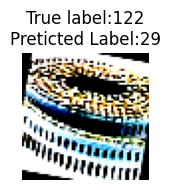


 Train loss at epoch 0: 840.127900  --> 8.401e+02, accuracy 0.0218-> (2.1774)%


Val loss at epoch 0: 97.895292  --> 9.790e+01, accuracy 0.0364-> (3.6400)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 1: 807.806085  --> 8.078e+02, accuracy 0.0382-> (3.8155)%


Val loss at epoch 1: 94.352022  --> 9.435e+01, accuracy 0.0540-> (5.4000)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 2: 784.262611  --> 7.843e+02, accuracy 0.0514-> (5.1429)%


Val loss at epoch 2: 90.911767  --> 9.091e+01, accuracy 0.0735-> (7.3500)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch3:



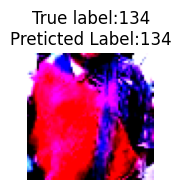


 Train loss at epoch 3: 760.932218  --> 7.609e+02, accuracy 0.0663-> (6.6262)%


Val loss at epoch 3: 88.049764  --> 8.805e+01, accuracy 0.0900-> (9.0000)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 4: 744.789402  --> 7.448e+02, accuracy 0.0794-> (7.9417)%


Val loss at epoch 4: 86.172532  --> 8.617e+01, accuracy 0.0990-> (9.9000)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 5: 729.019519  --> 7.290e+02, accuracy 0.0915-> (9.1512)%


Val loss at epoch 5: 84.306102  --> 8.431e+01, accuracy 0.1176-> (11.7600)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 6: 717.558111  --> 7.176e+02, accuracy 0.1002-> (10.0214)%


Val loss at epoch 6: 83.063041  --> 8.306e+01, accuracy 0.1243-> (12.4300)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 7: 707.170768  --> 7.072e+02, accuracy 0.1089-> (10.8893)%


Val loss at epoch 7: 82.263328  --> 8.226e

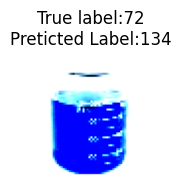


 Train loss at epoch 9: 689.768683  --> 6.898e+02, accuracy 0.1217-> (12.1714)%


Val loss at epoch 9: 80.524451  --> 8.052e+01, accuracy 0.1472-> (14.7200)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch18:



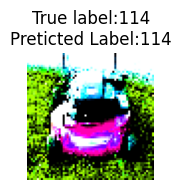


 Train loss at epoch 10: 682.415904  --> 6.824e+02, accuracy 0.1290-> (12.9048)%


Val loss at epoch 10: 79.793814  --> 7.979e+01, accuracy 0.1506-> (15.0600)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch26:



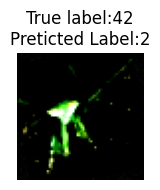


 Train loss at epoch 11: 675.189871  --> 6.752e+02, accuracy 0.1335-> (13.3524)%


Val loss at epoch 11: 79.344224  --> 7.934e+01, accuracy 0.1552-> (15.5200)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch153:



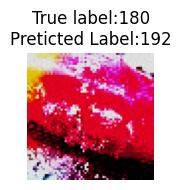


 Train loss at epoch 12: 669.417058  --> 6.694e+02, accuracy 0.1405-> (14.0536)%


Val loss at epoch 12: 78.647705  --> 7.865e+01, accuracy 0.1578-> (15.7800)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 13: 663.152986  --> 6.632e+02, accuracy 0.1452-> (14.5179)%


Val loss at epoch 13: 78.362663  --> 7.836e+01, accuracy 0.1601-> (16.0100)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 14: 659.227491  --> 6.592e+02, accuracy 0.1488-> (14.8774)%


Val loss at epoch 14: 78.203096  --> 7.820e+01, accuracy 0.1643-> (16.4300)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 15: 655.125771  --> 6.551e+02, accuracy 0.1522-> (15.2179)%


Val loss at epoch 15: 77.818202  --> 7.782e+01, accuracy 0.1659-> (16.5900)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch130:



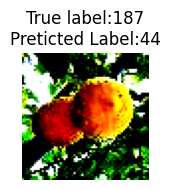


 Train loss at epoch 16: 653.108768  --> 6.531e+02, accuracy 0.1533-> (15.3298)%


Val loss at epoch 16: 77.848886  --> 7.785e+01, accuracy 0.1660-> (16.6000)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch15:



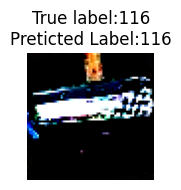


 Train loss at epoch 17: 649.544791  --> 6.495e+02, accuracy 0.1571-> (15.7083)%


Val loss at epoch 17: 77.602053  --> 7.760e+01, accuracy 0.1681-> (16.8100)%

Saving validation accuracy...

Saving training accuracy...


 Train loss at epoch 18: 648.943789  --> 6.489e+02, accuracy 0.1572-> (15.7238)%


Val loss at epoch 18: 77.678768  --> 7.768e+01, accuracy 0.1683-> (16.8300)%

Saving validation accuracy...

Saving training accuracy...


  Example image in  batch60:



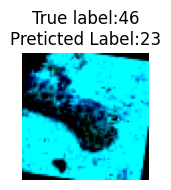


 Train loss at epoch 19: 648.480545  --> 6.485e+02, accuracy 0.1588-> (15.8821)%


Val loss at epoch 19: 77.559527  --> 7.756e+01, accuracy 0.1674-> (16.7400)%

Saving training accuracy...

++++++++++Best epoch was 18 ++++++++++++++++++++

++++++++++Best val accuracy was 16.8300 ++++++++++++++++++++

++++++++++Best train accuracy was 15.8821 ++++++++++++++++++++



In [37]:
## messo model_test per prova
model1 = model_test.to(device)

loss_train_list=[]
loss_val_list=[]
acc_train_list=[]
acc_val_list=[]
best_val_acc=0.0
best_epoch=0
best_train_acc=0.0

##num epochs spostato su initializzation

bar_out  = Output()
plot_out = Output()
bar_out_val  = Output()
display(bar_out,bar_out_val, plot_out)

#display(bar_out_val)


for epoch in  range(num_epochs):

  train(model1, train_loader, optimizer, loss_train, epoch, loss_train_list, acc_train_list, debug_mode=False)
  validate(model1, validation_loader, loss_val_list, optimizer, loss_val, epoch, acc_val_list, debug_mode=False)
  scheduler.step()


  if(best_val_acc<acc_val_list[epoch]):
        print("Saving validation accuracy...\n")
        best_val_acc=acc_val_list[epoch]
        best_epoch=epoch
  if(best_train_acc<acc_train_list[epoch]):
        print("Saving training accuracy...\n")
        best_train_acc=acc_train_list[epoch]


  '''
  <3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3<3
  <3<3<3<3<3<3
  <3<3<3<3<3<3<3<3 LY <3<3<3<3<3<3<3<3
  '''

end=time.time()
print(f"++++++++++Best epoch was {best_epoch} ++++++++++++++++++++\n")
print(f"++++++++++Best val accuracy was {best_val_acc*100.0:.4f} ++++++++++++++++++++\n")
print(f"++++++++++Best train accuracy was {best_train_acc*100.0:.4f} ++++++++++++++++++++\n")


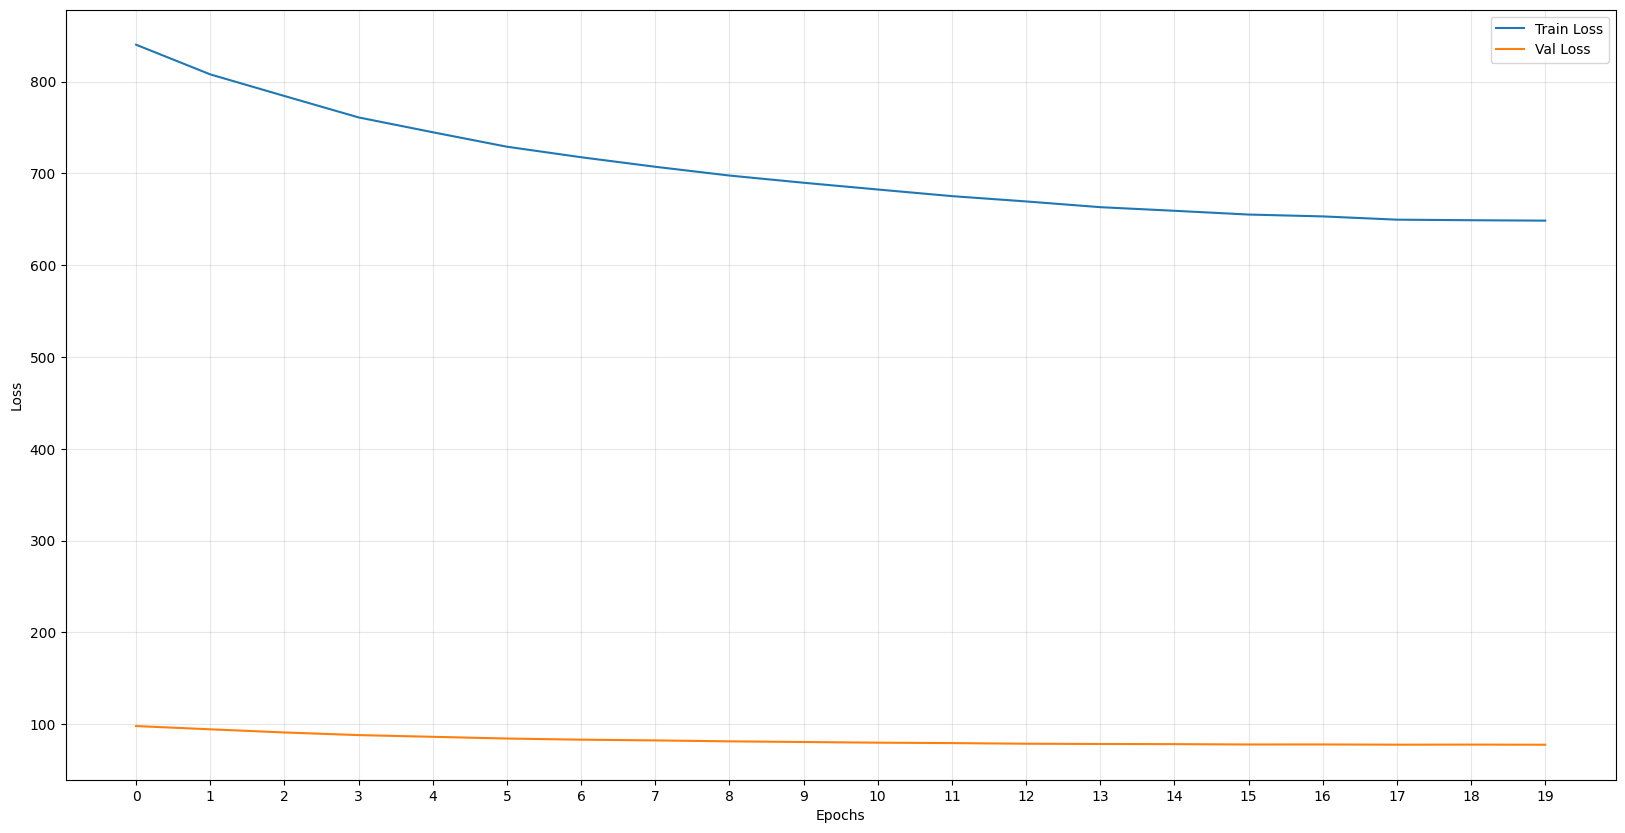

In [38]:
#VisionTransformer_ 10.8% LR: 0.#Train and Validation Loss

list_epochs=list(range(0,len(loss_train_list)))
plt.figure(figsize=(20, 10))
plt.plot(loss_train_list, label="Train Loss")
plt.plot(loss_val_list, label="Val Loss")
plt.legend(loc="upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(list_epochs)
plt.grid(linestyle='-',alpha=0.3)
# Logaritmic axis for y


plt.grid(linestyle='-',alpha=0.3)
plt.show()
#

###Save Model

In [41]:
!pwd && ls -la
model_name = "VisionTransformer_20epochs"
if device_name in device_list:
  print("Saving model..")
  torch.save(model1.state_dict(), path_saves+"/"+model_name)
  print("Model Saved!")


/content
total 16
drwxr-xr-x 1 root root 4096 Jun  3 14:04 .
drwxr-xr-x 1 root root 4096 Jul  1 15:06 ..
drwxr-xr-x 4 root root 4096 Jun  3 14:04 .config
drwxr-xr-x 1 root root 4096 Jun  3 14:04 sample_data
Saving model..
Model Saved!


#Test Phase